<a href="https://colab.research.google.com/github/Fabio-RibeiroB/BBK-Applied-ML/blob/main/BBK_AML_CW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AML Coursework - Cyberattack Classifier

Author: Fabio Ribeiro Brady

Acknowledgments: Thanks to our teachers Paul and Seongil, fellow students Hanif and Charlton, and Jie for their help.

## Connect Google Drive and Import Necessary Libraries

In [1]:
from pandas import read_csv
from pandas import set_option
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from __future__ import print_function
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input 
from tensorflow.keras.regularizers import l1 
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from numpy import set_printoptions 
from tensorflow.keras.models import load_model
from pandas.core.frame import DataFrame
from pandas import merge 
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from os import path
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)
import json
from scipy import stats
from keras.callbacks import ModelCheckpoint, TensorBoard
#from keras import regularizers
#from keras import optimizers
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import pickle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


Either Mount your drive with the data or upload it to colab. If you don't mount
then ignore this cell.

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


If you don't mount Google drive then upload the files on the left-hand side
on colab and run the next cell. 

If you do have drive, change the *root* variable below to your directory in
google drive that has the datasets.

In [2]:
# Training and Test sets

root ='/content/drive/MyDrive/AML Data/' # path for my data in google drive
try:
  
  if path.isdir(root):
    
    train_csv = root +  'train_imperson_without4n7_balanced_data.csv'
    test_csv = root +  'test_imperson_without4n7_balanced_data.csv'

  else:
    train_csv = 'train_imperson_without4n7_balanced_data.csv'
    test_csv = 'test_imperson_without4n7_balanced_data.csv'

except:
  print('You must have the datasets saved before continuing.')

## Loading the Data

I have a txt file with all the names of the features copied from the website.

In [3]:
# Get the names of all features from txt file
features_txt = open(root+"features.txt", "r")
features = []
feature = features_txt.readline()

while feature != "":
  feature = feature.rstrip("\n")
  if feature not in features:
    features.append(feature)
  else:
    features.append(feature + '2') # There is a duplicate name, add 2 to the end
  feature = features_txt.readline()

features_txt.close()


# remove features 4 and 7 as required by specification as they provide temporal 
# information which may cause unfair prediction

features.remove('frame.time_epoch')
features.remove('frame.time_relative')


# Put into pd dataframe, remove first row which is just a variable number
train_df = read_csv(train_csv, names=features)
train_df = train_df.drop([0])

# Class distribution - check if balanced
class_counts=train_df.groupby('class').size()
print(class_counts) # Balanced data

train_df.head()

class
0    48522
1    48522
dtype: int64


,frame.interface_id,frame.dlt,frame.offset_shift,frame.time_delta,frame.time_delta_displayed,frame.len,frame.cap_len,frame.marked,frame.ignored,radiotap.version,radiotap.pad,radiotap.length,radiotap.present.tsft,radiotap.present.flags,radiotap.present.rate,radiotap.present.channel,radiotap.present.fhss,radiotap.present.dbm_antsignal,radiotap.present.dbm_antnoise,radiotap.present.lock_quality,radiotap.present.tx_attenuation,radiotap.present.db_tx_attenuation,radiotap.present.dbm_tx_power,radiotap.present.antenna,radiotap.present.db_antsignal,radiotap.present.db_antnoise,radiotap.present.rxflags,radiotap.present.xchannel,radiotap.present.mcs,radiotap.present.ampdu,radiotap.present.vht,radiotap.present.reserved,radiotap.present.rtap_ns,radiotap.present.vendor_ns,radiotap.present.ext,radiotap.mactime,radiotap.flags.cfp,radiotap.flags.preamble,radiotap.flags.wep,radiotap.flags.frag,...,wlan_mgt.fixed.fragment,wlan_mgt.fixed.sequence,wlan_mgt.tagged.all,wlan_mgt.ssid,wlan_mgt.ds.current_channel,wlan_mgt.tim.dtim_count,wlan_mgt.tim.dtim_period,wlan_mgt.tim.bmapctl.multicast,wlan_mgt.tim.bmapctl.offset,wlan_mgt.country_info.environment,wlan_mgt.rsn.version,wlan_mgt.rsn.gcs.type,wlan_mgt.rsn.pcs.count,wlan_mgt.rsn.akms.count,wlan_mgt.rsn.akms.type,wlan_mgt.rsn.capabilities.preauth,wlan_mgt.rsn.capabilities.no_pairwise,wlan_mgt.rsn.capabilities.ptksa_replay_counter,wlan_mgt.rsn.capabilities.gtksa_replay_counter,wlan_mgt.rsn.capabilities.mfpr,wlan_mgt.rsn.capabilities.mfpc,wlan_mgt.rsn.capabilities.peerkey,wlan_mgt.tcprep.trsmt_pow,wlan_mgt.tcprep.link_mrg,wlan.wep.iv,wlan.wep.key,wlan.wep.icv,wlan.tkip.extiv,wlan.ccmp.extiv,wlan.qos.tid,wlan.qos.priority,wlan.qos.eosp,wlan.qos.ack,wlan.qos.amsdupresent,wlan.qos.buf_state_indicated,wlan.qos.bit4,wlan.qos.txop_dur_req,wlan.qos.buf_state_indicated2,data.len,class
1,0,0,0,0.000066,0.000066,0.009150,0.009150,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36865,0,0,0,0,...,0,0.0,0,0.000000,0.00000,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0
2,0,0,0,0.000014,0.000014,0.000000,0.000000,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36867,0,0,0,0,...,0,0.0,0,0.000000,0.00000,0.000000,0.000000,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0
3,0,0,0,0.035528,0.035528,0.070588,0.070588,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36871,0,0,0,0,...,0,0.0,1,0.001459,0.46154,0.000000,0.007936,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0
4,0,0,0,0.005128,0.005128,0.094771,0.094771,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36876,0,0,0,0,...,0,0.0,1,0.000875,0.46154,0.000000,0.003968,0,0,0.0,0.000015,0.007843,0.000031,0.000016,1,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0
5,0,0,0,0.035116,0.035116,0.070588,0.070588,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36880,0,0,0,0,...,0,0.0,1,0.001459,0.46154,0.004566,0.007936,0,0,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0


In [4]:
# Loading testing dataset

test_df = read_csv(test_csv, names=features, header=0)
print(test_df.shape)
test_df.head()

# features 4 and 7 are already removed in testing dataset

(40158, 153)


,frame.interface_id,frame.dlt,frame.offset_shift,frame.time_delta,frame.time_delta_displayed,frame.len,frame.cap_len,frame.marked,frame.ignored,radiotap.version,radiotap.pad,radiotap.length,radiotap.present.tsft,radiotap.present.flags,radiotap.present.rate,radiotap.present.channel,radiotap.present.fhss,radiotap.present.dbm_antsignal,radiotap.present.dbm_antnoise,radiotap.present.lock_quality,radiotap.present.tx_attenuation,radiotap.present.db_tx_attenuation,radiotap.present.dbm_tx_power,radiotap.present.antenna,radiotap.present.db_antsignal,radiotap.present.db_antnoise,radiotap.present.rxflags,radiotap.present.xchannel,radiotap.present.mcs,radiotap.present.ampdu,radiotap.present.vht,radiotap.present.reserved,radiotap.present.rtap_ns,radiotap.present.vendor_ns,radiotap.present.ext,radiotap.mactime,radiotap.flags.cfp,radiotap.flags.preamble,radiotap.flags.wep,radiotap.flags.frag,...,wlan_mgt.fixed.fragment,wlan_mgt.fixed.sequence,wlan_mgt.tagged.all,wlan_mgt.ssid,wlan_mgt.ds.current_channel,wlan_mgt.tim.dtim_count,wlan_mgt.tim.dtim_period,wlan_mgt.tim.bmapctl.multicast,wlan_mgt.tim.bmapctl.offset,wlan_mgt.country_info.environment,wlan_mgt.rsn.version,wlan_mgt.rsn.gcs.type,wlan_mgt.rsn.pcs.count,wlan_mgt.rsn.akms.count,wlan_mgt.rsn.akms.type,wlan_mgt.rsn.capabilities.preauth,wlan_mgt.rsn.capabilities.no_pairwise,wlan_mgt.rsn.capabilities.ptksa_replay_counter,wlan_mgt.rsn.capabilities.gtksa_replay_counter,wlan_mgt.rsn.capabilities.mfpr,wlan_mgt.rsn.capabilities.mfpc,wlan_mgt.rsn.capabilities.peerkey,wlan_mgt.tcprep.trsmt_pow,wlan_mgt.tcprep.link_mrg,wlan.wep.iv,wlan.wep.key,wlan.wep.icv,wlan.tkip.extiv,wlan.ccmp.extiv,wlan.qos.tid,wlan.qos.priority,wlan.qos.eosp,wlan.qos.ack,wlan.qos.amsdupresent,wlan.qos.buf_state_indicated,wlan.qos.bit4,wlan.qos.txop_dur_req,wlan.qos.buf_state_indicated2,data.len,class
0,0,0,0,0.002547,0.002547,0.98824,0.98824,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88219,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.22215,0.0,0.47729,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.98674,0
1,0,0,0,0.003296,0.003296,0.98824,0.98824,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88220,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.35106,0.0,0.18516,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.98674,0
2,0,0,0,0.003285,0.003285,0.98824,0.98824,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88220,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.43700,0.0,0.47541,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.98674,0
3,0,0,0,0.005942,0.005942,0.00000,0.00000,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88220,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.00000,0
4,0,0,0,0.001519,0.001519,0.98824,0.98824,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88220,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.0,0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.63621,0.0,0.89971,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.98674,0


## Generating Features



### Stacked Autoencoder

First seperating out the features and target variable

In [5]:
# Separate input X and output Y for test and training data

X_train = train_df.iloc[:,0:-1] #Features
Y_train = train_df.iloc[:,-1] # Class/target

X_test= test_df.iloc[:,0:-1] #Features
Y_test = test_df.iloc[:,-1] # Class

# Check that I successfully seperated the features and target
print(f'Training dataset dimensions: Input variables{X_train.shape}, Target{Y_train.shape}')
print(f'Testing dataset dimensions: Input variables{X_test.shape}, Target{Y_test.shape}')

Training dataset dimensions: Input variables(97044, 152), Target(97044,)
Testing dataset dimensions: Input variables(40158, 152), Target(40158,)


The testing dataset has about half the observations and there are 152 features
at present.

Define a stacked autoencoder model to generate new features

In [6]:
def stacked_autoencoder_model(input_size=152, hidden1_size=100, hidden2_size=30, code_size=10, sparse=False, regval=10e-7):
    '''
    A Stacked Autoencoder model.

    Purpose: to find a dense representation of the data that can be used to
             extract 10 new features.

    Architecture: Encoder (input, two hidden layers), Code (One hidden layer),
                  Decoder (two hidden layers and one output later).

    The Code is the dense representation and the code size is the number of 
    generated features. The output layer is an attempt to recreate the input
    from the Code representation.

    '''

    # Encoder

    input_data = Input(shape=(input_size,)) # Input() is used to instantiate a Keras tensor.

    hidden1 = Dense(hidden1_size, activation='relu')(input_data) 

    hidden2 = Dense(hidden2_size, activation='relu')(hidden1)

    # Code layer
    
    if sparse:
             code = Dense(code_size, activation='relu', activity_regularizer = l1(regval))(hidden2) # Seo does l2 regularisation
    else:
             code = Dense(code_size, activation='relu')(hidden2)
    
    # Decoder

    hidden3 = Dense(hidden2_size, activation='relu')(code)

    hidden4 = Dense(hidden2_size, activation = 'relu')(hidden3)

    output_data = Dense(input_size, activation='sigmoid')(hidden4)



    stacked_autoencoder = Model(input_data, output_data) 
    encoder = Model(input_data, code)


    

    return stacked_autoencoder, encoder

  

Because I intend that this code is used by someone else, I have to be careful
I don't always refer to my google drive and that I don't try and load a file that is not saved.

If the model is save somewhere, then load it. If not train and save.

In [7]:
# Use the SAE model above and compile
batch_size=32
num_epoch = 100


stacked_autoencoder, encoder = stacked_autoencoder_model(sparse=True)
encoder.compile(optimizer='adam', loss='binary_crossentropy') 
stacked_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


# the model is saved somewhere:

if path.isfile('encoder.h5'): # saved locally
  encoder = load_model('encoder.h5')
  stacked_autoencoder = load_model('stacked_autoencoder.h5')

elif path.isfile(root+'encoder.h5'): # saved on the drive?
  encoder = load_model(root+'encoder.h5')
  stacked_autoencoder = load_model(root+'stacked_autoencoder.h5')

# the model is not save somehwere (train and save):

elif path.isdir(root): # drive is mounted with AML data directory
   checkpointer = ModelCheckpoint(filepath=root+"stacked_autoencoder.h5", verbose=0, save_best_only=True)
   tensorboard = TensorBoard(log_dir=root+'logs', histogram_freq=0, write_graph=True, write_images=True)
   history = stacked_autoencoder.fit(X_train, X_train, epochs=num_epoch, batch_size=batch_size, 
                              shuffle=True, validation_data=(X_test, X_test), 
                              verbose=1, callbacks=[checkpointer, tensorboard]).history
   encoder.save(root+'encoder.h5')

   with open(root+'/history.json', 'w') as f:
     json.dump(history, f)

else: # not saved: train and save (drive not mounted)

  checkpointer = ModelCheckpoint(filepath="./stacked_autoencoder.h5", verbose=0, 
                                 save_best_only=True)
  
  tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, 
                              write_images=True)
  history = stacked_autoencoder.fit(X_train, X_train, epochs=num_epoch, batch_size=batch_size, 
                              shuffle=True, validation_data=(X_test, X_test), 
                              verbose=1, callbacks=[checkpointer, tensorboard]).history
  encoder.save('encoder.h5')
  with open('./history.json', 'w') as f:
    json.dump(history, f)

Epoch 1/100
3033/3033 [==============================] - 8s 2ms/step - loss: 0.0489 - val_loss: 0.4260
Epoch 2/100
3033/3033 [==============================] - 7s 2ms/step - loss: 0.0341 - val_loss: 0.4825
Epoch 3/100
3033/3033 [==============================] - 7s 2ms/step - loss: 0.0332 - val_loss: 0.4599
Epoch 4/100
3033/3033 [==============================] - 7s 2ms/step - loss: 0.0328 - val_loss: 0.4317
Epoch 5/100
3033/3033 [==============================] - 7s 2ms/step - loss: 0.0326 - val_loss: 0.4425
Epoch 6/100
3033/3033 [==============================] - 7s 2ms/step - loss: 0.0324 - val_loss: 0.4709
Epoch 7/100
3033/3033 [==============================] - 7s 2ms/step - loss: 0.0323 - val_loss: 0.4848
Epoch 8/100
3033/3033 [==============================] - 7s 2ms/step - loss: 0.0322 - val_loss: 0.4773
Epoch 9/100
3033/3033 [==============================] - 7s 2ms/step - loss: 0.0322 - val_loss: 0.4737
Epoch 10/100
3033/3033 [==============================] - 7s 2ms/step - l

In [8]:
stacked_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 152)]             0         
                                                                 
 dense (Dense)               (None, 100)               15300     
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
 dense_3 (Dense)             (None, 30)                330       
                                                                 
 dense_4 (Dense)             (None, 30)                930       
                                                                 
 dense_5 (Dense)             (None, 152)               4712  

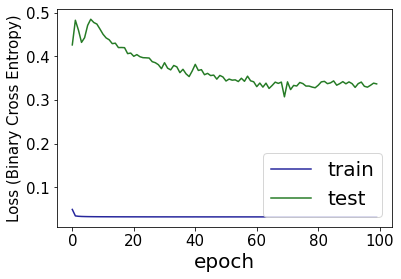

In [10]:
 if path.isfile('./history.json'):

   history_dict = json.load(open('./history.json', 'r')) # get history json locally

else:

  history_dict = json.load(open(root+'/history.json', 'r')) # or get json from drive

plt.plot(history_dict['loss'], color='darkblue', alpha=0.85)
plt.plot(history_dict['val_loss'], color='darkgreen', alpha=0.85)
plt.ylabel('Loss (Binary Cross Entropy)', fontsize=15)
#plt.ylim((0.0,0.1))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('epoch', fontsize=20)
plt.legend(['train', 'test'], fontsize=20)#, loc='center right')


In [11]:
# MSE check
print('Train MSE: ', mean_squared_error(X_train, stacked_autoencoder.predict(X_train)))
print('Test MSE: ', mean_squared_error(X_test, stacked_autoencoder.predict(X_test)))


Train MSE:  2.0982784679761333e-05
Test MSE:  0.016172745369441903


### Using the encoder to create new features

Use the encoder part of the stacked autoencoder to generate the features for the trainind dataset. There are 10 new features and we stick them on the end of the original features.

In [12]:
# Use the encoder to find the new features for the training dataset

X_train_encoder = encoder.predict(X_train)

print(f'The dimensions of the array containing the new features: {X_train_encoder.shape}')

# new feature names (numbering from 0-9 for now but could be 152 to 161)
new_features = [i for i in range(10)]
features += new_features

print(f'List of all {len(features)} features: {features}')

# Turn the new features from X_train_encoder into a Dataframe
X_train_encoder_df = DataFrame(X_train_encoder, index=range(1, X_train_encoder.shape[0]+1), columns=new_features)

# Add the new features merging on index (could combine with other methods)
X_train_merger = merge(X_train, X_train_encoder_df, left_index=True, right_index=True)

# Dataframe containing all the features new and old (without class label in df)
X_train_merger.head()


The dimensions of the array containing the new features: (97044, 10)
List of all 163 features: ['frame.interface_id', 'frame.dlt', 'frame.offset_shift', 'frame.time_delta', 'frame.time_delta_displayed', 'frame.len', 'frame.cap_len', 'frame.marked', 'frame.ignored', 'radiotap.version', 'radiotap.pad', 'radiotap.length', 'radiotap.present.tsft', 'radiotap.present.flags', 'radiotap.present.rate', 'radiotap.present.channel', 'radiotap.present.fhss', 'radiotap.present.dbm_antsignal', 'radiotap.present.dbm_antnoise', 'radiotap.present.lock_quality', 'radiotap.present.tx_attenuation', 'radiotap.present.db_tx_attenuation', 'radiotap.present.dbm_tx_power', 'radiotap.present.antenna', 'radiotap.present.db_antsignal', 'radiotap.present.db_antnoise', 'radiotap.present.rxflags', 'radiotap.present.xchannel', 'radiotap.present.mcs', 'radiotap.present.ampdu', 'radiotap.present.vht', 'radiotap.present.reserved', 'radiotap.present.rtap_ns', 'radiotap.present.vendor_ns', 'radiotap.present.ext', 'radiotap

,frame.interface_id,frame.dlt,frame.offset_shift,frame.time_delta,frame.time_delta_displayed,frame.len,frame.cap_len,frame.marked,frame.ignored,radiotap.version,radiotap.pad,radiotap.length,radiotap.present.tsft,radiotap.present.flags,radiotap.present.rate,radiotap.present.channel,radiotap.present.fhss,radiotap.present.dbm_antsignal,radiotap.present.dbm_antnoise,radiotap.present.lock_quality,radiotap.present.tx_attenuation,radiotap.present.db_tx_attenuation,radiotap.present.dbm_tx_power,radiotap.present.antenna,radiotap.present.db_antsignal,radiotap.present.db_antnoise,radiotap.present.rxflags,radiotap.present.xchannel,radiotap.present.mcs,radiotap.present.ampdu,radiotap.present.vht,radiotap.present.reserved,radiotap.present.rtap_ns,radiotap.present.vendor_ns,radiotap.present.ext,radiotap.mactime,radiotap.flags.cfp,radiotap.flags.preamble,radiotap.flags.wep,radiotap.flags.frag,...,wlan_mgt.country_info.environment,wlan_mgt.rsn.version,wlan_mgt.rsn.gcs.type,wlan_mgt.rsn.pcs.count,wlan_mgt.rsn.akms.count,wlan_mgt.rsn.akms.type,wlan_mgt.rsn.capabilities.preauth,wlan_mgt.rsn.capabilities.no_pairwise,wlan_mgt.rsn.capabilities.ptksa_replay_counter,wlan_mgt.rsn.capabilities.gtksa_replay_counter,wlan_mgt.rsn.capabilities.mfpr,wlan_mgt.rsn.capabilities.mfpc,wlan_mgt.rsn.capabilities.peerkey,wlan_mgt.tcprep.trsmt_pow,wlan_mgt.tcprep.link_mrg,wlan.wep.iv,wlan.wep.key,wlan.wep.icv,wlan.tkip.extiv,wlan.ccmp.extiv,wlan.qos.tid,wlan.qos.priority,wlan.qos.eosp,wlan.qos.ack,wlan.qos.amsdupresent,wlan.qos.buf_state_indicated,wlan.qos.bit4,wlan.qos.txop_dur_req,wlan.qos.buf_state_indicated2,data.len,0,1,2,3,4,5,6,7,8,9
1,0,0,0,0.000066,0.000066,0.009150,0.009150,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36865,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0.000000,3.287009,0.821215,0.045596,2.414864,0.0,0.062647,0.367712,1.829995,0.000000
2,0,0,0,0.000014,0.000014,0.000000,0.000000,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36867,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,3.167517,3.931273,0.822927,0.000000,2.284106,0.0,0.030559,0.019600,1.244777,0.000000
3,0,0,0,0.035528,0.035528,0.070588,0.070588,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36871,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0.717561,0.909453,1.301643,0.000000,0.000000,0.0,0.000000,2.301676,2.992853,0.394109
4,0,0,0,0.005128,0.005128,0.094771,0.094771,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36876,0,0,0,0,...,0.0,0.000015,0.007843,0.000031,0.000016,1,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,2.203101,0.212814,2.065558,0.000000,0.000000,0.0,0.000000,1.905471,2.129444,1.735722
5,0,0,0,0.035116,0.035116,0.070588,0.070588,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.36880,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.5,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0.709183,0.890407,1.291876,0.000000,0.000000,0.0,0.000000,2.261238,3.020002,0.333939


The new features need to be scaled between 0 and 1.
X_train_scaled will be the dataset we will used for training the algorithms and performing feature selection on.

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
X_train_scaled = scaler.fit_transform(X_train_merger) 
X_train_scaled = DataFrame(X_train_scaled)
X_train_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161
0,0.0,0.0,0.0,0.000064,0.000064,0.009150,0.009150,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394895,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.415073,0.193513,0.010148,0.385884,0.0,0.011688,0.062672,0.275746,0.000000
1,0.0,0.0,0.0,0.000012,0.000012,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394916,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.491480,0.496428,0.193917,0.000000,0.364989,0.0,0.005701,0.003341,0.187565,0.000000
2,0.0,0.0,0.0,0.036308,0.036308,0.070588,0.070588,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.394959,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111339,0.114843,0.306723,0.000000,0.000000,0.0,0.000000,0.392294,0.450968,0.101417
3,0.0,0.0,0.0,0.005238,0.005238,0.094771,0.094771,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.395013,0.0,0.0,0.0,0.0,...,0.0,1.0,0.500006,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.341839,0.026873,0.486734,0.000000,0.000000,0.0,0.000000,0.324766,0.320868,0.446659
4,0.0,0.0,0.0,0.035887,0.035887,0.070588,0.070588,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.395055,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110039,0.112438,0.304421,0.000000,0.000000,0.0,0.000000,0.385402,0.455059,0.085934


We need the testing dataset to also have the same features. Use the encoder again.

In [14]:
# Use the encoder to find the new features for the testing dataset

X_test_encoder = encoder.predict(X_test)

print('Dimension of the array of new features: ', X_test_encoder.shape)


X_test_encoder_df = DataFrame(X_test_encoder, index=range(X_test_encoder.shape[0]))

X_test_encoder_df.head()

# Add the new features to the 

X_test_merger = merge(X_test, X_test_encoder_df, left_index=True, right_index=True)

# Dataframe containing all the features new and old (without class label in df)
print('Dimensions of dataframe with testing orignal + new features: ', X_test_merger.shape)
X_test_merger.head()


Dimension of the array of new features:  (40158, 10)
Dimensions of dataframe with testing orignal + new features:  (40158, 162)


,frame.interface_id,frame.dlt,frame.offset_shift,frame.time_delta,frame.time_delta_displayed,frame.len,frame.cap_len,frame.marked,frame.ignored,radiotap.version,radiotap.pad,radiotap.length,radiotap.present.tsft,radiotap.present.flags,radiotap.present.rate,radiotap.present.channel,radiotap.present.fhss,radiotap.present.dbm_antsignal,radiotap.present.dbm_antnoise,radiotap.present.lock_quality,radiotap.present.tx_attenuation,radiotap.present.db_tx_attenuation,radiotap.present.dbm_tx_power,radiotap.present.antenna,radiotap.present.db_antsignal,radiotap.present.db_antnoise,radiotap.present.rxflags,radiotap.present.xchannel,radiotap.present.mcs,radiotap.present.ampdu,radiotap.present.vht,radiotap.present.reserved,radiotap.present.rtap_ns,radiotap.present.vendor_ns,radiotap.present.ext,radiotap.mactime,radiotap.flags.cfp,radiotap.flags.preamble,radiotap.flags.wep,radiotap.flags.frag,...,wlan_mgt.country_info.environment,wlan_mgt.rsn.version,wlan_mgt.rsn.gcs.type,wlan_mgt.rsn.pcs.count,wlan_mgt.rsn.akms.count,wlan_mgt.rsn.akms.type,wlan_mgt.rsn.capabilities.preauth,wlan_mgt.rsn.capabilities.no_pairwise,wlan_mgt.rsn.capabilities.ptksa_replay_counter,wlan_mgt.rsn.capabilities.gtksa_replay_counter,wlan_mgt.rsn.capabilities.mfpr,wlan_mgt.rsn.capabilities.mfpc,wlan_mgt.rsn.capabilities.peerkey,wlan_mgt.tcprep.trsmt_pow,wlan_mgt.tcprep.link_mrg,wlan.wep.iv,wlan.wep.key,wlan.wep.icv,wlan.tkip.extiv,wlan.ccmp.extiv,wlan.qos.tid,wlan.qos.priority,wlan.qos.eosp,wlan.qos.ack,wlan.qos.amsdupresent,wlan.qos.buf_state_indicated,wlan.qos.bit4,wlan.qos.txop_dur_req,wlan.qos.buf_state_indicated2,data.len,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0.002547,0.002547,0.98824,0.98824,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88219,0,0,0,0,...,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.22215,0.0,0.47729,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.98674,1.550486,2.790347,1.528054,0.628073,4.759115,0.0,2.524491,0.000000,0.142752,0.000000
1,0,0,0,0.003296,0.003296,0.98824,0.98824,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88220,0,0,0,0,...,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.35106,0.0,0.18516,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.98674,1.366504,3.028993,1.537899,0.598044,4.824603,0.0,2.660367,0.000000,0.283684,0.000000
2,0,0,0,0.003285,0.003285,0.98824,0.98824,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88220,0,0,0,0,...,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.43700,0.0,0.47541,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.98674,1.457213,2.783448,1.540324,0.623520,4.897572,0.0,2.678107,0.000000,0.222068,0.000000
3,0,0,0,0.005942,0.005942,0.00000,0.00000,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88220,0,0,0,0,...,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.0,0.00000,0.0,0.0,0.00000,0.00000,0,0,0,0,0,0,0,0.00000,3.086645,4.965770,2.905700,0.842021,3.729125,0.0,0.000000,0.241568,0.622465,0.000000
4,0,0,0,0.001519,0.001519,0.98824,0.98824,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0.88220,0,0,0,0,...,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.63621,0.0,0.89971,0.0,0.0,0.16667,0.16667,0,0,0,0,0,0,0,0.98674,1.973759,1.284731,1.017474,0.316988,4.967815,0.0,2.439198,0.000000,0.121058,0.797914


Scale the new features for testing

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
X_test_scaled = scaler.fit_transform(X_test_merger) 
set_printoptions(precision=3) 
X_test_scaled = DataFrame(X_test_scaled)
X_test_scaled.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161
0,0.0,0.0,0.0,0.002809,0.002809,0.98824,0.98824,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.901749,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.222181,0.0,0.477300,0.0,0.0,0.16667,0.16667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.98674,0.335730,0.431009,0.236269,0.120496,0.659865,0.0,0.573822,0.000000,0.016929,0.000000
1,0.0,0.0,0.0,0.003637,0.003637,0.98824,0.98824,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.901759,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.351109,0.0,0.185164,0.0,0.0,0.16667,0.16667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.98674,0.295892,0.467871,0.237791,0.114735,0.668945,0.0,0.604707,0.000000,0.033643,0.000000
2,0.0,0.0,0.0,0.003624,0.003624,0.98824,0.98824,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.901759,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.437061,0.0,0.475420,0.0,0.0,0.16667,0.16667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.98674,0.315534,0.429943,0.238166,0.119622,0.679062,0.0,0.608739,0.000000,0.026336,0.000000
3,0.0,0.0,0.0,0.006561,0.006561,0.00000,0.00000,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.901759,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.668358,0.767033,0.449282,0.161542,0.517054,0.0,0.000000,0.034914,0.073820,0.000000
4,0.0,0.0,0.0,0.001672,0.001672,0.98824,0.98824,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.901759,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.636299,0.0,0.899728,0.0,0.0,0.16667,0.16667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.98674,0.427382,0.198445,0.157323,0.060814,0.688802,0.0,0.554435,0.000000,0.014357,0.147584


### Checking the scaling with describe

In [16]:
X_train_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161
count,97044.0,97044.0,97044.0,97044.000000,97044.000000,97044.000000,97044.000000,97044.0,97044.0,97044.0,97044.0,97044.000000,97044.000000,97044.000000,97044.0,97044.000000,97044.0,97044.000000,97044.0,97044.0,97044.0,97044.0,97044.0,97044.000000,97044.0,97044.0,97044.000000,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.000000,97044.0,97044.0,97044.0,97044.0,...,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.0,97044.0,97044.00000,97044.0,97044.0,97044.0,97044.0,97044.00000,97044.0,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.0,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.000000,97044.0,97044.000000,97044.000000,97044.000000,97044.000000
mean,0.0,0.0,0.0,0.006387,0.006387,0.193837,0.193837,0.0,0.0,0.0,0.0,0.999784,0.999784,0.999784,0.0,0.999784,0.0,0.999784,0.0,0.0,0.0,0.0,0.0,0.999784,0.0,0.0,0.999784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.764569,0.0,0.0,0.0,0.0,...,0.001483,0.021537,0.010774,0.020782,0.021537,0.021537,0.0,0.0,0.00001,0.0,0.0,0.0,0.0,0.00001,0.0,0.273149,0.003775,0.261462,0.005572,0.000400,0.028436,0.028436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178474,0.221833,0.195308,0.341452,0.048086,0.319747,0.0,0.088918,0.068133,0.318958,0.059744
std,0.0,0.0,0.0,0.015883,0.015883,0.354444,0.354444,0.0,0.0,0.0,0.0,0.014709,0.014709,0.014709,0.0,0.014709,0.0,0.014709,0.0,0.0,0.0,0.0,0.0,0.014709,0.0,0.0,0.014709,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.117626,0.0,0.0,0.0,0.0,...,0.038187,0.145165,0.072636,0.141320,0.145165,0.145165,0.0,0.0,0.00321,0.0,0.0,0.0,0.0,0.00321,0.0,0.260131,0.036295,0.262518,0.060826,0.015372,0.062765,0.062765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.360078,0.170427,0.184977,0.158273,0.090119,0.205854,0.0,0.183391,0.121025,0.161125,0.095552
min,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.001471,0.001471,0.037908,0.037908,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.700640,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.098727,0.044426,0.255881,0.000000,0.159174,0.0,0.000000,0.000000,0.167194,0.000000
50%,0.0,0.0,0.0,0.003785,0.003785,0.037908,0.037908,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.811117,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.325880,0.000000,0.201342,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023873,0.153475,0.122066,0.290304,0.000000,0.226964,0.0,0.000000,0.029116,0.429107,0.037761
75%,0.0,0.0,0.0,0.006043,0.006043,0.054902,0.054902,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.822193,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.446670,0

In [17]:
X_test_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161
count,40158.0,40158.0,40158.0,40158.000000,40158.000000,40158.000000,40158.000000,40158.0,40158.0,40158.0,40158.0,40158.000000,40158.000000,40158.000000,40158.0,40158.000000,40158.0,40158.000000,40158.0,40158.0,40158.0,40158.0,40158.0,40158.000000,40158.0,40158.0,40158.000000,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.000000,40158.0,40158.0,40158.0,40158.0,...,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.0,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.0,40158.000000,40158.0,40158.0,40158.0,40158.0,40158.0,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.000000,40158.0,40158.000000,40158.000000,40158.000000,40158.000000
mean,0.0,0.0,0.0,0.005609,0.005609,0.200639,0.200639,0.0,0.0,0.0,0.0,0.999701,0.999701,0.999701,0.0,0.999701,0.0,0.999701,0.0,0.0,0.0,0.0,0.0,0.999701,0.0,0.0,0.999701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.965111,0.0,0.0,0.0,0.0,...,0.004051,0.031401,0.031401,0.029645,0.031401,0.031401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.121969,0.045437,0.196163,0.009374,0.011528,0.028011,0.028011,0.0,0.000025,0.0,0.0,0.0,0.0,0.0,0.185022,0.346482,0.333631,0.417396,0.196348,0.430805,0.0,0.151988,0.122755,0.222999,0.164349
std,0.0,0.0,0.0,0.017896,0.017896,0.371463,0.371463,0.0,0.0,0.0,0.0,0.017284,0.017284,0.017284,0.0,0.017284,0.0,0.017284,0.0,0.0,0.0,0.0,0.0,0.017284,0.0,0.0,0.017284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041098,0.0,0.0,0.0,0.0,...,0.060856,0.174401,0.174401,0.167001,0.174401,0.174401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.249727,0.114639,0.310219,0.079168,0.084312,0.062511,0.062511,0.0,0.004990,0.0,0.0,0.0,0.0,0.0,0.377552,0.161960,0.212462,0.148469,0.174638,0.197281,0.0,0.243782,0.177392,0.148543,0.148340
min,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.001499,0.001499,0.016993,0.016993,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.925995,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.002652,0.241547,0.171382,0.370231,0.044466,0.359307,0.0,0.000000,0.000000,0.090601,0.000000
50%,0.0,0.0,0.0,0.002494,0.002494,0.016993,0.016993,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.988858,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.002652,0.270998,0.279858,0.400636,0.133030,0.427745,0.0,0.000000,0.035412,0.247742,0.164447
75%,0.0,0.0,0.0,0.003489,0.003489,0.060131,0.060131,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.997138,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.028017,0.000000,0.369895,0.000000,

Features are now numbers from 0 to 162 for simplicity rather than names

## Feature Selection

### Remove correlated features

In [24]:
corr = X_train_scaled.corr()
X_train_scaled2 = X_train_scaled
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = X_train_scaled.columns[columns]
X_train_scaled = X_train_scaled[selected_columns]

print('After the correlation filter, the new dimensions are:', X_train_scaled.shape()

features = X_train_scaled.columns
print('The features left are: ', features)

Int64Index([  0,   3,   7,   8,   9,  14,  21,  24,  27,  32,  33,  35,  37,
             38,  41,  42,  44,  46,  50,  51,  52,  53,  55,  56,  57,  58,
             60,  62,  66,  67,  69,  71,  72,  73,  74,  82,  83,  84,  85,
             87,  88,  89,  90,  96,  97,  99, 100, 101, 102, 104, 106, 109,
            110, 111, 112, 116, 118, 119, 121, 122, 123, 128, 129, 131, 132,
            133, 134, 136, 137, 138, 139, 140, 141, 144, 145, 146, 147, 148,
            149, 150, 152, 153, 154, 155, 156, 157, 159, 160, 161],
           dtype='int64')


### Mutual Information Filter

I first used Mutual Information to filter out any features with zero MI with the target variable. These have zero relevance. There are many ways to feature
select. I could also remove correlated features.

In [25]:
# Mutual Information Filter

print('Starting size of dataset: ', X_train_scaled.shape)

# calculate MI
MI_array = mutual_info_classif(X_train_scaled, Y_train)

print('Number of features before MI filter: ', MI_array.shape)

# new features

features_kept = []

for i in range(len(MI_array)):
  if MI_array[i] != 0:
      features_kept.append(features[i])

  elif MI_array[i] == 0:
    if features[i] in X_train_scaled.columns:
      X_train_scaled.drop(features[i], axis=1, inplace=True)

print('The features selected after removing features with zero MI with target: ', features_kept)
print('Number of features after filter (should be same as no. of columns in X_train_scaled now): ', len(features_kept))

X_train_scaled.head()



Starting size of dataset:  (97044, 89)
Number of features before MI filter:  (89,)
The features selected after removing features with zero MI with target:  [0, 3, 7, 9, 24, 35, 37, 38, 44, 46, 50, 55, 57, 58, 60, 62, 66, 67, 69, 72, 73, 74, 82, 83, 84, 87, 89, 90, 97, 101, 104, 106, 109, 111, 116, 118, 119, 121, 122, 123, 129, 134, 136, 137, 138, 139, 140, 144, 146, 147, 152, 153, 154, 155, 156, 157, 159, 160, 161]
Number of features after filter (should be same as no. of columns in X_train_scaled now):  59


,0,3,7,9,24,35,37,38,44,46,50,55,57,58,60,62,66,67,69,72,73,74,82,83,84,87,89,90,97,101,104,106,109,111,116,118,119,121,122,123,129,134,136,137,138,139,140,144,146,147,152,153,154,155,156,157,159,160,161
0,0.0,0.000064,0.0,0.0,0.0,0.394895,0.0,0.0,0.88679,0.0,0.0,0.0,0.0,0.70423,0.0,0.0,0.0,0.0,0.0,0.003034,0.001137,0.012821,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.415073,0.193513,0.010148,0.385884,0.0,0.062672,0.275746,0.000000
1,0.0,0.000012,0.0,0.0,0.0,0.394916,0.0,0.0,0.43396,0.0,0.0,0.0,0.0,0.70423,0.0,0.0,0.0,0.0,0.0,0.000000,0.002274,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.491480,0.496428,0.193917,0.000000,0.364989,0.0,0.003341,0.187565,0.000000
2,0.0,0.036308,0.0,0.0,0.0,0.394959,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.59155,0.0,0.0,0.0,0.0,0.0,0.000000,0.000569,0.006410,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.239785,0.0,0.0,0.0,0.001467,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111339,0.114843,0.306723,0.000000,0.000000,0.0,0.392294,0.450968,0.101417
3,0.0,0.005238,0.0,0.0,0.0,0.395013,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.14085,0.0,0.0,0.0,0.0,0.0,0.000000,0.000569,0.006410,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.839820,0.0,0.0,0.0,0.000880,0.0,0.500006,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.341839,0.026873,0.486734,0.000000,0.000000,0.0,0.324766,0.320868,0.446659
4,0.0,0.035887,0.0,0.0,0.0,0.395055,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.61972,0.0,0.0,0.0,0.0,0.0,0.000000,0.000569,0.006410,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.239790,0.0,0.0,0.0,0.001467,1.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.110039,0.112438,0.304421,0.000000,0.000000,0.0,0.385402,0.455059,0.085934


There's still quite a lot of features left. Let's take the top 20 highest MI with the target.

In [26]:
# sort in order of decreasing MI
MI_top_20 = sorted(list(zip(MI_array, features)), reverse=True)[:20]

print('Highest MI values and their features: ', MI_top_20, end='\n\n')

count=0
kept_generated_features = []

features_MI_top_20 = [x[1] for x in MI_top_20]

for feat in features_MI_top_20:
  if feat >= 152:
    count+=1
    kept_generated_features.append(feat)

print(f'There are {count} generated features in the top 20 ranked by MI. These are: ', kept_generated_features) 
print()
print('Here are all the top 20 after MI selection: ', features_MI_top_20) # best features from MI
X_train_scaled = X_train_scaled[features_MI_top_20] # keep only top 20

X_train_scaled.head()


Highest MI values and their features:  [(0.6487819899618176, 35), (0.6057406731316066, 160), (0.5758822169549325, 137), (0.5750086091289017, 139), (0.564168414892356, 156), (0.56294353372626, 153), (0.5173048198745347, 152), (0.48543195461531274, 74), (0.4773746585069618, 73), (0.4652003885528564, 161), (0.4466015004140278, 3), (0.40131068458473007, 154), (0.39550344247817004, 159), (0.3932548761092456, 58), (0.3060413914347606, 44), (0.27372659151126943, 72), (0.2718218355285571, 155), (0.05542957753823341, 67), (0.03019953928525787, 116), (0.028550171935224133, 104)]

There are 8 generated features in the top 20 ranked by MI. These are:  [160, 156, 153, 152, 161, 154, 159, 155]

Here are all the top 20 after MI selection:  [35, 160, 137, 139, 156, 153, 152, 74, 73, 161, 3, 154, 159, 58, 44, 72, 155, 67, 116, 104]


,35,160,137,139,156,153,152,74,73,161,3,154,159,58,44,72,155,67,116,104
0,0.394895,0.275746,0.0,0.0,0.385884,0.415073,0.000000,0.012821,0.001137,0.000000,0.000064,0.193513,0.062672,0.70423,0.88679,0.003034,0.010148,0.0,0.000000,0.000000
1,0.394916,0.187565,0.0,0.0,0.364989,0.496428,0.491480,0.000000,0.002274,0.000000,0.000012,0.193917,0.003341,0.70423,0.43396,0.000000,0.000000,0.0,0.000000,0.000000
2,0.394959,0.450968,0.0,0.0,0.000000,0.114843,0.111339,0.006410,0.000569,0.101417,0.036308,0.306723,0.392294,0.59155,0.00000,0.000000,0.000000,0.0,0.001467,0.239785
3,0.395013,0.320868,0.0,0.0,0.000000,0.026873,0.341839,0.006410,0.000569,0.446659,0.005238,0.486734,0.324766,0.14085,0.00000,0.000000,0.000000,0.0,0.000880,0.839820
4,0.395055,0.455059,0.0,0.0,0.000000,0.112438,0.110039,0.006410,0.000569,0.085934,0.035887,0.304421,0.385402,0.61972,0.00000,0.000000,0.000000,0.0,0.001467,0.239790


### Tree Wrapper

I then use an extremely-randomised tree classifier to rank feature importance.
Remember that the numbering of features starts from 0.

In [27]:
# Tree Wrapper

model = ExtraTreesClassifier()
model.fit(X_train_scaled, Y_train)
importances = model.feature_importances_ 
wrapper_top_10 = sorted(list(zip(importances, features_MI_top_20)), reverse=True)[:10]
print('Highest importance and feature number', wrapper_top_10, end='\n\n')

final_features = [x[1] for x in wrapper_top_10]
print('Final Selected Features: ', final_features, end='\n\n')

X_train_scaled = X_train_scaled[final_features]

count=0
kept_generated_features_2 = []

for feat in final_features:
  if feat >= 152:
    count+=1
    kept_generated_features_2.append(feat)


print(f'After feature selection, there are {count} generated features. These are: ', kept_generated_features) 
X_train_scaled.head()

Highest importance and feature number [(0.18416014821570398, 44), (0.17159652218866125, 160), (0.09972716948563293, 152), (0.07825798706824992, 153), (0.06908531853538571, 156), (0.06803147683944734, 35), (0.05788256139096735, 139), (0.055469475322325, 137), (0.035152167954165946, 67), (0.030129411353672416, 58)]

Final Selected Features:  [44, 160, 152, 153, 156, 35, 139, 137, 67, 58]

After feature selection, there are 4 generated features. These are:  [160, 156, 153, 152, 161, 154, 159, 155]


,44,160,152,153,156,35,139,137,67,58
0,0.88679,0.275746,0.000000,0.415073,0.385884,0.394895,0.0,0.0,0.0,0.70423
1,0.43396,0.187565,0.491480,0.496428,0.364989,0.394916,0.0,0.0,0.0,0.70423
2,0.00000,0.450968,0.111339,0.114843,0.000000,0.394959,0.0,0.0,0.0,0.59155
3,0.00000,0.320868,0.341839,0.026873,0.000000,0.395013,0.0,0.0,0.0,0.14085
4,0.00000,0.455059,0.110039,0.112438,0.000000,0.395055,0.0,0.0,0.0,0.61972


### Data visualisation on new features

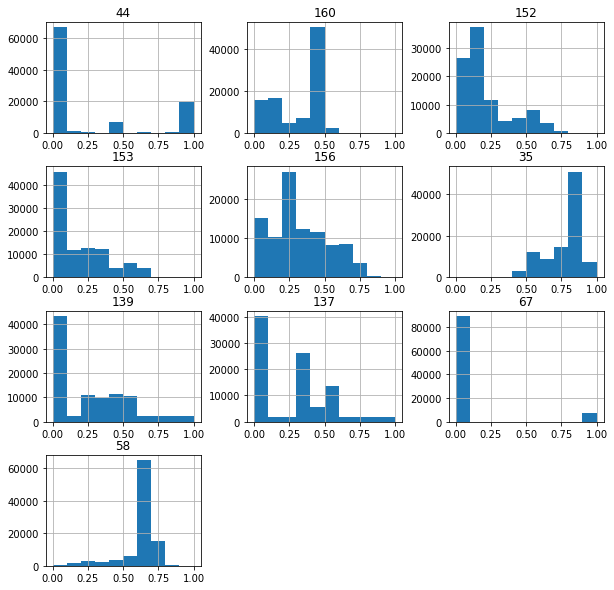

In [28]:
X_train_scaled.hist(figsize=(10,10))
plt.show()

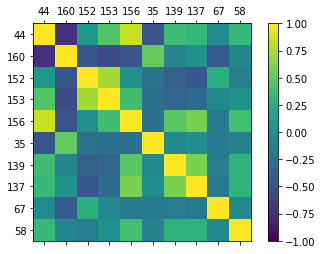

In [29]:
# Correlation Matrix Plot
'''
correlations = X_train_scaled.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

'''
correlations = X_train_scaled.corr() 
# plot correlation matrix 
fig = plt.figure() 
ax = fig.add_subplot(111) 
cax = ax.matshow(correlations, vmin=-1, vmax=1) 
fig.colorbar(cax) 
ticks = np.arange(0,10,1) 
ax.set_xticks(ticks) 
ax.set_yticks(ticks) 
ax.set_xticklabels(X_train_scaled.columns) 
ax.set_yticklabels(X_train_scaled.columns) 
plt.show()

In [30]:
X_train_scaled.columns

Int64Index([44, 160, 152, 153, 156, 35, 139, 137, 67, 58], dtype='int64')

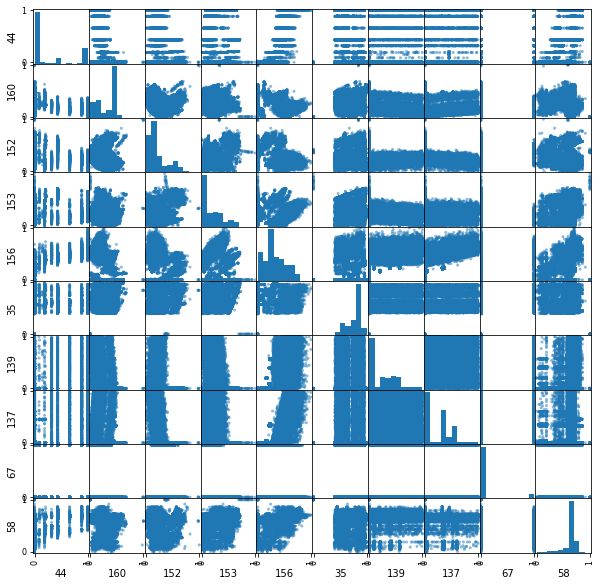

In [31]:
from pandas.plotting import scatter_matrix 
scatter_matrix(X_train_scaled, figsize=[10, 10]) 
plt.show()

We have to remove the same columns in the testing set.

In [32]:
# Make sure the testing dataset has the same columns

X_test_scaled = X_test_scaled[[x[1] for x in wrapper_top_10]]
print(X_test_scaled.shape)
X_test_scaled.head()

(40158, 10)


,44,160,152,153,156,35,139,137,67,58
0,1.00000,0.016929,0.335730,0.431009,0.659865,0.901749,0.477300,0.222181,0.0,0.661974
1,1.00000,0.033643,0.295892,0.467871,0.668945,0.901759,0.185164,0.351109,0.0,0.661974
2,1.00000,0.026336,0.315534,0.429943,0.679062,0.901759,0.475420,0.437061,0.0,0.647890
3,0.43396,0.073820,0.668358,0.767033,0.517054,0.901759,0.000000,0.000000,0.0,0.732394
4,1.00000,0.014357,0.427382,0.198445,0.688802,0.901759,0.899728,0.636299,1.0,0.661974


Save the scaled test and train features to google drive since they are import dataframes.

In [33]:
try:
  X_test_scaled.to_csv(root+'X_test_scaled.csv', index=False)
  X_train_scaled.to_csv(root+'X_train_scaled.csv', index=False)

except Exception as e:
  print(e)

## Building ML Algorithms

### Short listing algorithms with cross-validation

In [34]:
# X and Y values for input and output arrays
try:
  if path.isdir(root):
    X_train_scaled = read_csv(root+'X_train_scaled.csv')
    X_test_scaled = read_csv(root+'X_test_scaled.csv')
    print(f'Successfully loaded scaled training {X_train_scaled.shape} and testing datasets {X_test_scaled.shape}')
except Exception as e:
  print(e)

try:
  X = X_train_scaled.values
  Y = Y_train.values
except Exception as e:
  print(e)

X_train_scaled.head()

Successfully loaded scaled training (97044, 10) and testing datasets (40158, 10)


,44,160,152,153,156,35,139,137,67,58
0,0.88679,0.275746,0.000000,0.415073,0.385884,0.394895,0.0,0.0,0.0,0.70423
1,0.43396,0.187565,0.491480,0.496428,0.364989,0.394916,0.0,0.0,0.0,0.70423
2,0.00000,0.450968,0.111339,0.114843,0.000000,0.394959,0.0,0.0,0.0,0.59155
3,0.00000,0.320868,0.341839,0.026873,0.000000,0.395013,0.0,0.0,0.0,0.14085
4,0.00000,0.455059,0.110039,0.112438,0.000000,0.395055,0.0,0.0,0.0,0.61972


First I created a neural network classifier (MLP). One neuron for output for binary classifier (on or off).

In [35]:
# MLP Classifier

def create_MLP_model():
    model = Sequential()
    model.add(Dense(12, input_dim=10, activation='relu')) 
    model.add(Dense(8, activation='relu')) 
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def build_MLP():
  model = create_MLP_model()
  return KerasClassifier(build_fn=create_MLP_model, epochs=3, batch_size=10, verbose=0)

The next cell takes a while to run. It's going to do 10-fold CV
on a bunch of different algoritms to see which perform best based on accuracy.

In [36]:
%%time
# SHORT-LISTING ALGORITHMS



# Models for CV
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('ET', ExtraTreesClassifier()))
models.append(('XGB', XGBClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC())) - taking too long
models.append(('MLP', build_MLP()))


results = []
names = []
scoring = 'accuracy'

for name, model in models:
 kfold = KFold(n_splits=10, random_state=7,shuffle=True) # 10-FOLD
 cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
 results.append(cv_results)
 names.append(name)
 msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
 print(msg)


LR: 0.971322 (0.001424)
ET: 0.999794 (0.000113)
XGB: 0.999279 (0.000248)
KNN: 0.999361 (0.000194)
CART: 0.999310 (0.000153)
RF: 0.999608 (0.000234)
NB: 0.969127 (0.002086)
MLP: 0.995693 (0.001221)
CPU times: user 7min 47s, sys: 22 s, total: 8min 9s
Wall time: 8min 49s


Boxplots subplots to show the CV performance of each algorithm.

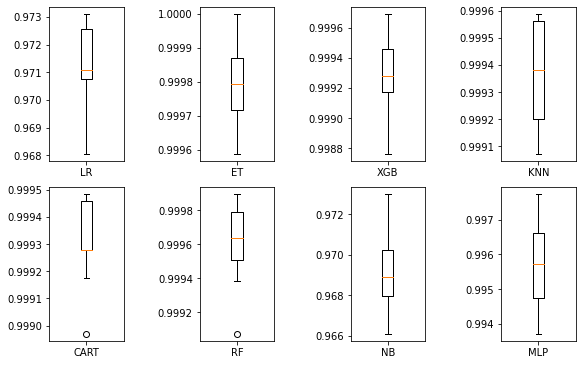

In [37]:
x, y = 2, 4
fig, ax = plt.subplots(x, y)
fig.tight_layout(pad=0, h_pad=0, w_pad=2)
fig.set_figheight(5)
fig.set_figwidth(8)

# same box plots on separate figures
for i in range(1, len(names)+1):
  plt.subplot(x, y, i)
  plt.boxplot(results[i-1])
  plt.xticks([1], [names[i-1]])
  

plt.show()

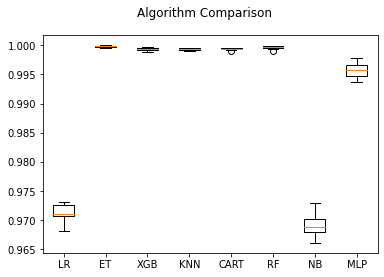

In [38]:
# boxplot algorithm comparison

fig = plt.figure() 
fig.suptitle('Algorithm Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.show()

The best performing algorithms are ET, XGB and RF. Let's take them to the next
stage: Tuning. They also ran relatively quickly.

## Tuning

### Random Forest tuning

Start by applying a Grid search for Random Forest

Will only tune again if you don't have the model saved.

In [48]:
%%time
# Grid Search for Algorithm Tuning

if path.isfile(root+'RF_tuned.sav'):
  with open(root+'RF_tuned.sav', 'rb') as f:
    RF_tuned = pickle.load(f)


elif path.isfile('./RF_tuned.sav'):
   with open('RF_tuned.sav', 'rb') as f:
    RF_tuned = pickle.load(f)

else:

  # Define parameters
  #max_depth=[8, 16, 20]
  #n_estimators = [25, 50, 100]
  param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
  # Create the parameter grid
  param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)

  # Build the gridsearch
  model = RandomForestClassifier()
  grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, scoring='roc_auc')
  grid_results = grid.fit(X, Y)

  # Summarise the results in a readable format
  print("Best CV accuracy for classifier: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))

  # Best Random Forest
  RF_tuned = grid_results.best_estimator_
  
  #save
  try:
    with open(root+'RF_tuned.sav', 'wb') as f:
      pickle.dump(RF_tuned, f)

  except:
    with open('RF_tuned.sav', 'wb') as f:
      pickle.dump(RF_tuned, f)


Best CV accuracy for classifier: [0.98  0.994 0.993 0.985 0.985 0.994 0.995 0.984 0.991], using {'max_depth': 20, 'n_estimators': 25}
CPU times: user 2min 56s, sys: 376 ms, total: 2min 57s
Wall time: 2min 56s


### XGBoost tuning


Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree)

Tune regularization parameters (lambda, alpha)

Colab has restarted a few times here because I think the paramater grid was too large.

In [43]:
%%time
# Grid Search for Algorithm Tuning
if path.isfile(root+'XGB_tuned.sav'):
  with open(root+'XGB_tuned.sav', 'rb') as f:
    XGB_tuned = pickle.load(f)


elif path.isfile('./XGB_tuned.sav'):
   with open('XGB_tuned.sav', 'rb') as f:
    XGB_tuned = pickle.load(f)

else:
  

  # Define parameters
  param_grid = {
          'max_depth': [5, 10, 20],
          #'min_child_weight': np.arange(0.01, 0.5, 0.01),
          #'min_child_weight': [1, 5, 10],
          'gamma': [0.1, 0.5, 1],
          #'learning_rate': [0.05, 0.1, 0.2, 0.3],
          #'subsample': [0.6, 0.8, 1.0],
          #'colsample_bytree': np.arange(0.1,1.0,0.1),
          'reg_alpha': [0.1, 0.2, 0.3],
          #'reg_lambda': np.arange(0, 1, 0.2)
          }

  # Do the gridsearch
  model = XGBClassifier()
  grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5)
  grid_results = grid.fit(X, Y)

  grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    # scoring = 'roc_auc', # note how you do scoring, can do other scoring methods
    cv = 5)

  # Summarise the results in a readable format
  print("Best CV accuracy for classifier for XGB: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))

  # Best Random Forest
  XGB_tuned = grid_results.best_estimator_

  #save somewhere appropriate
  try:
    with open(root+'XGB_tuned.sav', 'wb') as f:
      pickle.dump(XGB_tuned, f)

  except:
    with open('XGB_tuned.sav', 'wb') as f:
      pickle.dump(XGB_tuned, f)

Best CV accuracy for classifier for XGB: [0.805 0.805 0.805 0.805 0.805 0.805 0.805 0.805 0.805 0.805 0.805 0.805
 0.805 0.805 0.805 0.805 0.805 0.805 0.805 0.805 0.805 0.805 0.805 0.805
 0.805 0.805 0.805], using {'gamma': 0.5, 'max_depth': 10, 'reg_alpha': 0.2}
CPU times: user 14min 2s, sys: 523 ms, total: 14min 3s
Wall time: 13min 58s


### Extra-Tree tuning

In [ ]:
%%time
# Grid Search for Algorithm Tuning
if path.isfile(root+'ET_tuned.sav'):
  with open(root+'ET_tuned.sav', 'rb') as f:
    ET_tuned = pickle.load(f)


elif path.isfile('./ET_tuned.sav'):
   with open('ET_tuned.sav', 'rb') as f:
    ET_tuned = pickle.load(f)

else:
  

  # Define parameters
  param_grid = {
          'max_depth': [5, 10, 20],
          #'min_child_weight': np.arange(0.01, 0.5, 0.01),
          #'min_child_weight': [1, 5, 10],
          'gamma': [0.1, 0.5, 1],
          #'learning_rate': [0.05, 0.1, 0.2, 0.3],
          #'subsample': [0.6, 0.8, 1.0],
          #'colsample_bytree': np.arange(0.1,1.0,0.1),
          'reg_alpha': [0.1, 0.2, 0.3],
          #'reg_lambda': np.arange(0, 1, 0.2)
          }

  # Do the gridsearch
  model = ExtraTreesClassifier()
  grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5)
  grid_results = grid.fit(X, Y)

  grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    # scoring = 'roc_auc', # note how you do scoring, can do other scoring methods
    cv = 5)

  # Summarise the results in a readable format
  print("Best CV accuracy for classifier for ET: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))

  # Best Random Forest
  ET_tuned = grid_results.best_estimator_

  #save somewhere appropriate
  try:
    with open(root+'ET_tuned.sav', 'wb') as f:
      pickle.dump(ET_tuned, f)

  except:
    with open('ET_tuned.sav', 'wb') as f:
      pickle.dump(ET_tuned, f)

## Evaluation

Generate a report and confusion matrix for each tuned algorithm.

To run this section, make sure you loaded the algorithms by running the previous
section **Tuning**.

### Random Forest report

              precision    recall  f1-score   support

           0       0.81      0.98      0.88     20079
           1       0.98      0.76      0.86     20079

    accuracy                           0.87     40158
   macro avg       0.89      0.87      0.87     40158
weighted avg       0.89      0.87      0.87     40158



([<matplotlib.axis.XTick at 0x7fbdb6fb2450>,
 [Text(0.5, 0, 'Normal'), Text(1.5, 0, 'Attack')])

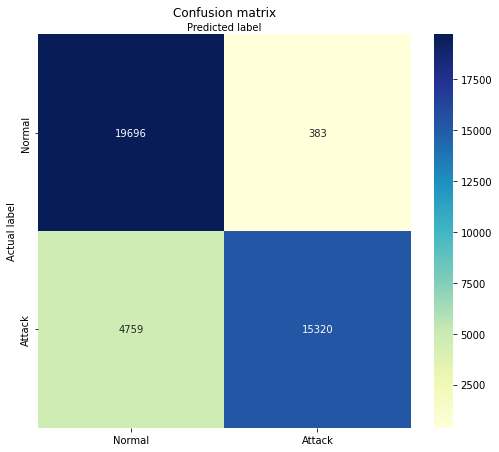

In [49]:
# run tuning to load the tuned Random
X_test = X_test_scaled.values
RFC = RF_tuned.fit(X, Y)
predicted = RFC.predict(X_test_scaled)
report = classification_report(Y_test, predicted)
print(report)

# Create a confusion matrix
cnf_matrix = confusion_matrix(Y_test, predicted)

# Create heatmap from the confusion matrix
class_names=['Normal', 'Attack'] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.yticks(tick_marks, class_names); plt.xticks(tick_marks, class_names)


              precision    recall  f1-score   support

           0       0.99      0.86      0.92     20079
           1       0.87      0.99      0.93     20079

    accuracy                           0.93     40158
   macro avg       0.93      0.93      0.93     40158
weighted avg       0.93      0.93      0.93     40158



([<matplotlib.axis.XTick at 0x7fbdadb73a50>,
 [Text(0.5, 0, 'Normal'), Text(1.5, 0, 'Attack')])

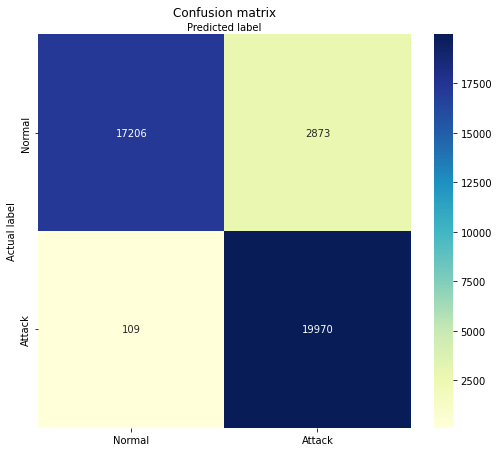

In [45]:
X_test = X_test_scaled.values
XGB_final = XGB_tuned.fit(X, Y)
XGB_predicted = XGB_tuned.predict(X_test)
report = classification_report(Y_test, XGB_predicted)
print(report)

# Create a confusion matrix
cnf_matrix = confusion_matrix(Y_test, XGB_predicted)

# Create heatmap from the confusion matrix
class_names=['Normal', 'Attack'] # name  of classes
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix')
plt.ylabel('Actual label'); plt.xlabel('Predicted label')
tick_marks = [0.5, 1.5]
plt.yticks(tick_marks, class_names); plt.xticks(tick_marks, class_names)
